In [8]:
import gdown
import pims
import torch as tr
import yaml
import numpy as np
import matplotlib.pyplot as plt

from vre.representations import build_representations_from_cfg
from vre.utils import get_project_root

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def dwd_video_if_needed() -> str:
    """download the video in the resources dir if not exist and return the path"""
    video_path = get_project_root() / "resources/testVideo.mp4"
    if not video_path.exists():
        video_path.parent.mkdir(exist_ok=True, parents=True)
        gdown.download("https://drive.google.com/uc?id=158U-W-Gal6eXxYtS1ca1DAAxHvknqwAk", f"{video_path}")
    return f"{video_path}"
video = pims.Video(dwd_video_if_needed())
print(video)

<FramesSequenceND>
Axes: 3
Axis 'x' size: 1280
Axis 'y' size: 720
Axis 't' size: 9021
Pixel Datatype: uint8


In [11]:

"""setup all representations we want to use, including one representation per device"""
device = "cuda" if tr.cuda.is_available() else "cpu"
all_representations_dict = yaml.safe_load(f"""
normals_svd(depth_dpt):
  type: normals
  name: depth-svd
  dependencies: [depth_dpt]
  parameters:
    sensor_fov: 75
    sensor_width: 3840
    sensor_height: 2160
    window_size: 11
depth_dpt:
  type: depth
  name: dpt
  dependencies: []
  parameters: {{}}
  vre_parameters:
    device: {device}
""")

video = pims.Video(dwd_video_if_needed())
print(video)
start_frame = 1000
end_frame = start_frame + 1

representations = build_representations_from_cfg(all_representations_dict)
print(representations)

[2024-10-06T16:42:08 VRE-DEBUG] Doing topological sort... (build_representations.py:build_representations_from_cfg:103)
[2024-10-06T16:42:08 VRE-INFO] Building 'depth'/'dpt' (vre name: depth_dpt) (build_representations.py:build_representation_from_cfg:81)


<FramesSequenceND>
Axes: 3
Axis 'x' size: 1280
Axis 'y' size: 720
Axis 't' size: 9021
Pixel Datatype: uint8


[2024-10-06T16:42:12 VRE-INFO] Explicit VRE parameters provided to 'depth_dpt' (build_representations.py:build_representation_from_cfg:87)
[2024-10-06T16:42:12 VRE-INFO] Building 'normals'/'depth-svd' (vre name: normals_svd(depth_dpt)) (build_representations.py:build_representation_from_cfg:81)


{'depth_dpt': [Representation] DepthDpt(depth_dpt), 'normals_svd(depth_dpt)': [Representation] DepthNormalsSVD(normals_svd(depth_dpt))}


## Run the representations for two particular frame

[2024-10-06T16:48:54 VRE-INFO] Loading weights from '/home/mihai/code/ml/video-representations-extractor/weights/depth_dpt_midas.pth' (depth_dpt.py:vre_setup:60)


3392


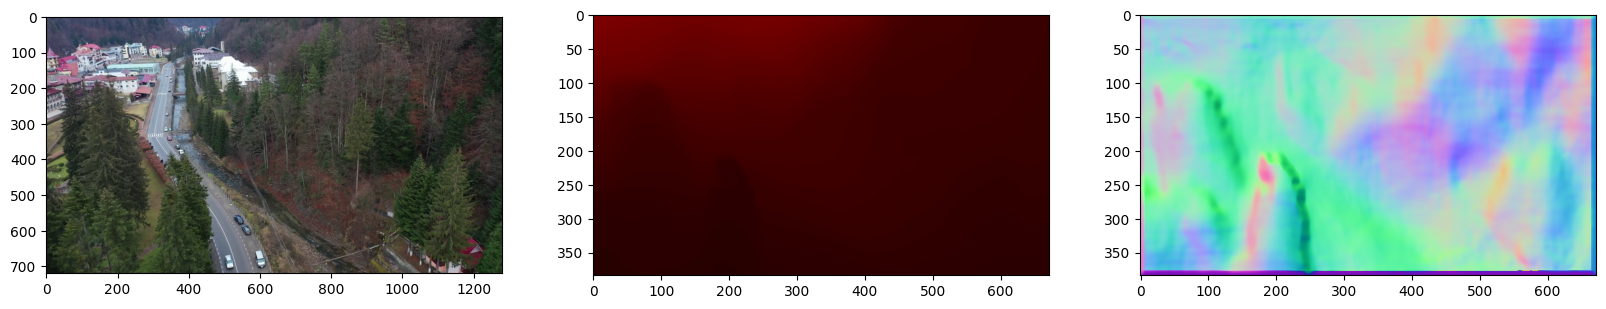

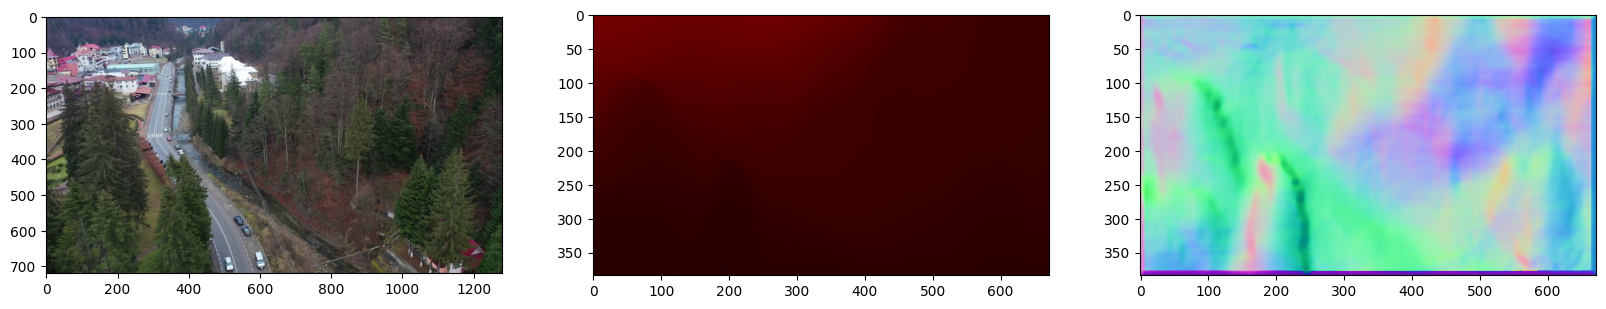

In [14]:
# inference setup (this is done inside VRE's main loop at run() as well)
depth, normals = representations["depth_dpt"], representations["normals_svd(depth_dpt)"]
depth.video = video
depth.video = video
depth.vre_setup(device=device)

np.random.seed(43)
start = np.random.randint(0, len(video) - 1)
print(start)
mb = 2
slc = slice(start, start + mb)

frames = np.array(video[slc])
y_depth = depth.make(frames)
y_depth_img = depth.make_images(frames, y_depth)
y_normals = normals.make(frames, y_depth)
y_normals_img = normals.make_images(frames, y_normals)
for i in range(len(frames)):
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(frames[i])
    ax[1].imshow(y_depth_img[i])
    ax[2].imshow(y_normals_img[i])
    plt.show()
